In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorly as tl

/Users/wu-jung/miniconda3/envs/deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using numpy backend.


## Load previously compiled data

The raw (ping-by-ping) data were averaged to get mean volume backscattering strengh (MVBS) and then cleaned up by PCP. This is the same set of data I used to run the Matlab PALM-NMF.

Note that **all echograms in this notebook are plotted upside-down**, so the DVM you see you opposite of what actually happens. In reality the animals move toward the surface during the night and move downward during the day.

In [3]:
# Load PCP-cleaned MVBS data
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/sample_data/'
MVBS_fname = '20150817-20151017_MVBS_PCPcleaned.h5'

import h5py
f = h5py.File(os.path.join(MVBS_path,MVBS_fname),'r')

In [4]:
# Load low-rank data
L = np.array(f['L'])
L_sep = np.array(f['L_sep'])
L_plot = np.array(f['L_plot'])
depth_bin_size = np.array(f['depth_bin_size'])
ping_per_day_mvbs = np.array(f['ping_per_day_mvbs'])
ping_time = np.array(f['ping_time'])
f.close()

The data is organized with dimension [frequency x number of days x depth x time of day].

In [5]:
L_sep.shape

(3, 62, 37, 144)

The 3 frequencies of data look like:

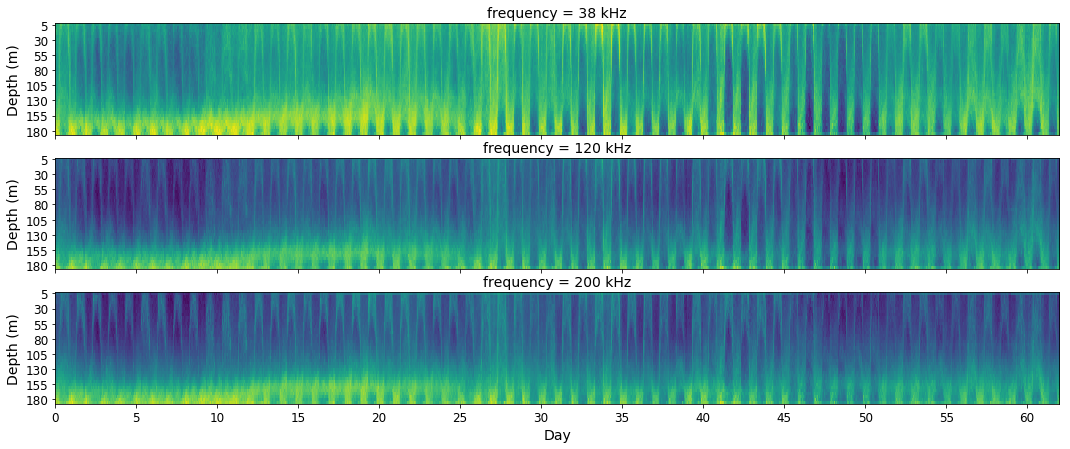

In [6]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,65*144,144*5))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

Here the y-axis starts at 5 m because I've cut off the top 5 m of data which include a lot of super strong surface reflection that can throw out the decomposition.

The data within each day look like:

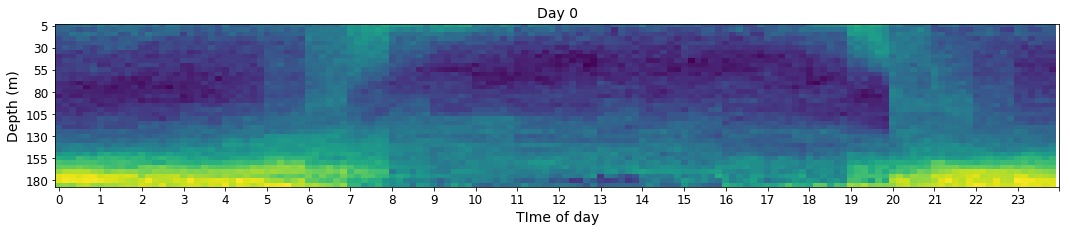

In [7]:
fig = plt.figure(figsize=(18,3))
plt.imshow(L_sep[0,0,:,:].squeeze(),aspect='auto')
plt.xticks(range(0,150,6), range(24), fontsize=12)
plt.yticks(np.arange(0,37,5), (np.arange(0,37,5)+1)*depth_bin_size, fontsize=12)
plt.xlabel('TIme of day', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('Day 0',fontsize=14)
plt.show()

Note how each hour is a vertical "stripe." This is because the data were collected from only the first 20 mins of each hour, so there is a discontinuity in the raw data itself.

### Try decimating data

In [35]:
# Average across time of day columns
tod_num = 12
L_sep_reduce = np.empty(np.hstack((np.array(L_sep.shape[:3]),int(L_sep.shape[-1]/tod_num))))
for i in np.arange(int(L_sep.shape[-1]/tod_num)):
    L_sep_reduce[:,:,:,i] = np.mean(L_sep[:,:,:,i*tod_num+np.arange(tod_num)],axis=3)

In [36]:
L_sep_reduce.shape

(3, 62, 37, 12)

On the grand scale it looks very similar to without averaging over the pings:

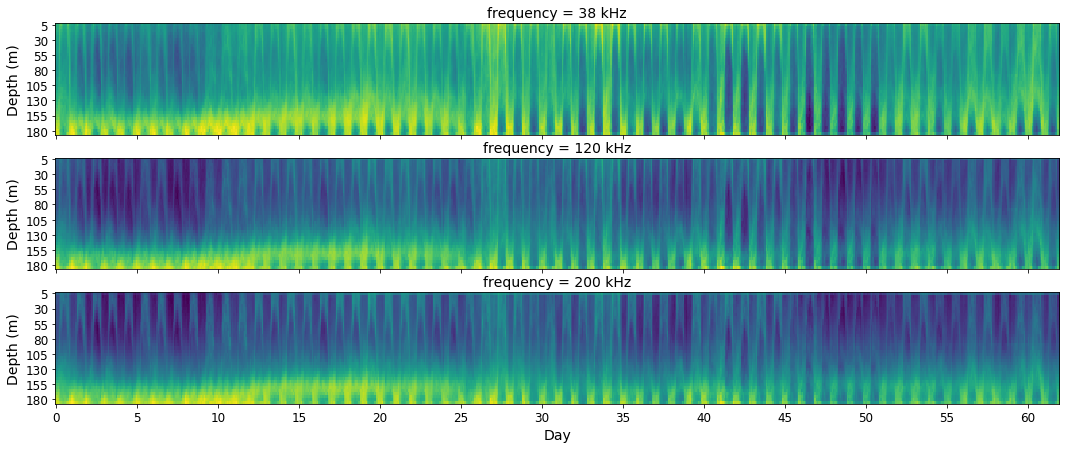

In [54]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(65*144/tod_num),int(144/tod_num*5)))
    ax[f].set_xticklabels(range(0,65,5))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

But obviously the effects are more prominent when you look at only a smaller number of days:

First we look at the original MVBS data for the first 10 days:

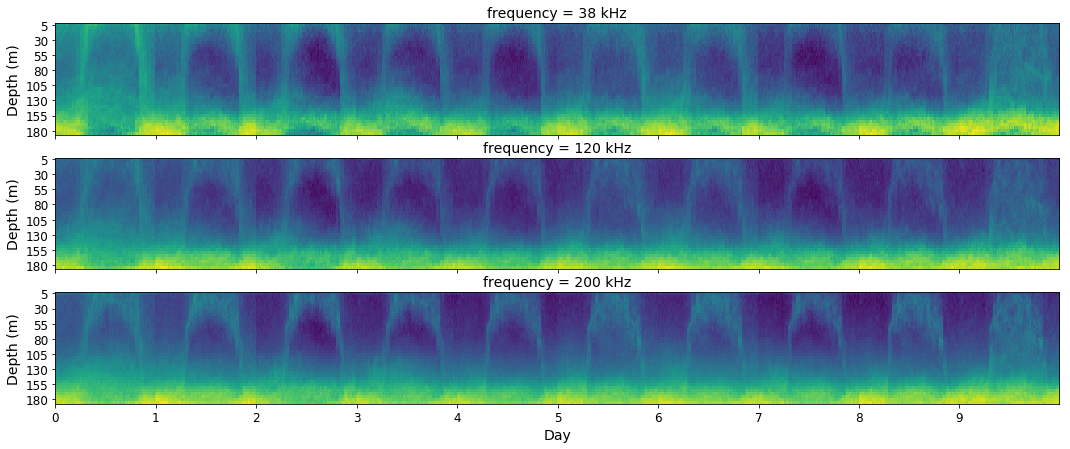

In [69]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,10*144,144))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

And then we compare it with the decimated data:

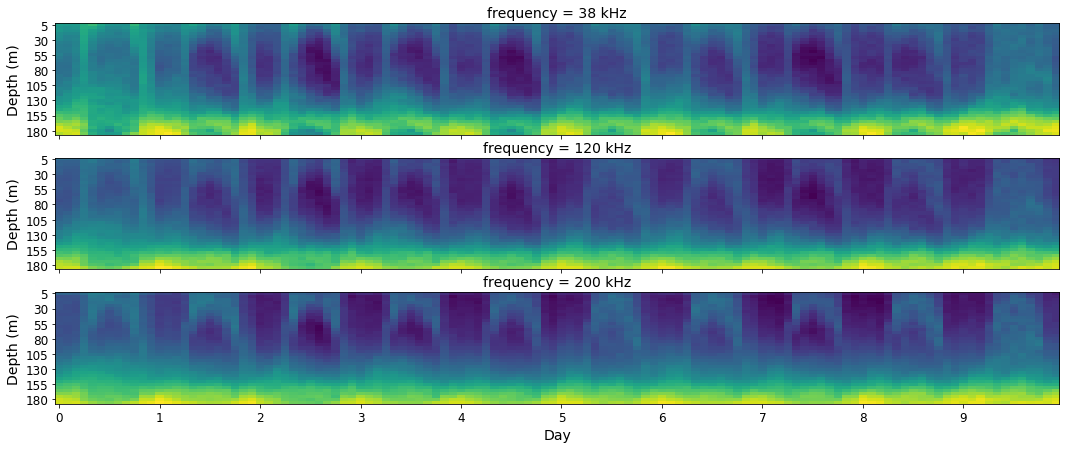

In [67]:
freq = [38,120,200]

fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
for f in range(3):
    ax[f].imshow(tl.unfold(tl.tensor(L_sep_reduce[f,:10,:,:].squeeze()),mode=1),aspect='auto')
    ax[f].set_xticks(range(0,int(10*144/tod_num),int(144/tod_num*1)))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
    ax[f].set_title('frequency = %d kHz' % freq[f], fontsize=14)

## Try parafac decomposition

Here I am using 1 frequency only just to see how things look like. I am not sure if throwing the 3 frequencies and making a 4D tensor makes sense because for that dimension there are only 3 frequencies of observation and this would force the parafac to have max rank=3...

In [70]:
# kruskal decomposition is parafac in tensorly
from tensorly.decomposition import parafac, non_negative_parafac
from tensorly.tenalg import kronecker, khatri_rao

In [71]:
sonar_tensor = tl.tensor(L_sep_reduce)

In [ ]:
kruskal_rank = 3
factors_kruskal = parafac(sonar_tensor, rank = kruskal_rank)
# factors_kruskal_nonneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [ ]:
[factors_kruskal[f].shape for f in range(len(factors_kruskal))]

In [ ]:
full_tensor = tl.kruskal_to_tensor(factors_kruskal)

In [ ]:
sonar_tensor[0,:,:,:].shape

TypeError: Invalid dimensions for image data

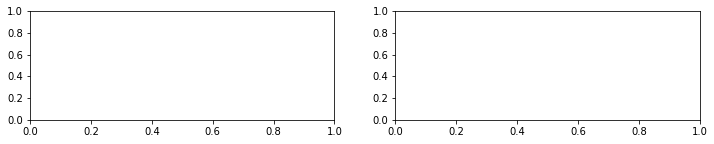

In [19]:
fig,ax = plt.subplots(1,2,figsize=(12,2))
ax[0].imshow(sonar_tensor[0,:,:,:],aspect='auto')
ax[0].set_title('Original')
ax[1].imshow(full_tensor[0,:,:,:],aspect='auto')
ax[1].set_title('Reconstructed, Kruskal rank=%d'%kruskal_rank)
plt.show()

In [61]:
sonar_tensor.shape

(62, 37, 144)

Below I am setting the decomposition rank = 4 because by observation (at the bottom of this notebook) that seems to be a good number. I'll discuss this more in this section.

I tried both the regular and the non-negative version of parafac. The former seems to give better results (with the same decomposition rank) but the latter is physically more sound (somewhat... we are operating in log-domain still here, so this is not entirely correct).

In [99]:
kruskal_rank = 4
factors_kruskal = parafac(sonar_tensor, rank = kruskal_rank)
factors_kruskal_nonneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank = kruskal_rank)

In [100]:
[print(f.shape) for f in factors_kruskal]

(62, 4)
(37, 4)
(144, 4)


[None, None, None]

In [101]:
full_tensor = tl.kruskal_to_tensor(factors_kruskal)
full_tensor_nonneg = tl.kruskal_to_tensor(factors_kruskal_nonneg)

### Compare data with reconstruction

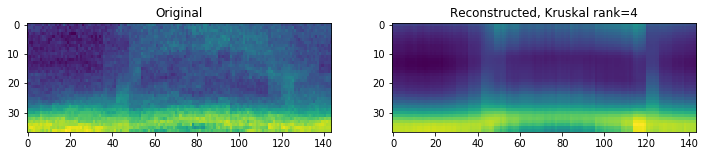

In [102]:
fig,ax = plt.subplots(1,2,figsize=(12,2))
ax[0].imshow(sonar_tensor[10,:,:],aspect='auto')
ax[0].set_title('Original')
ax[1].imshow(full_tensor[10,:,:],aspect='auto')
ax[1].set_title('Reconstructed, Kruskal rank=%d'%kruskal_rank)
plt.show()

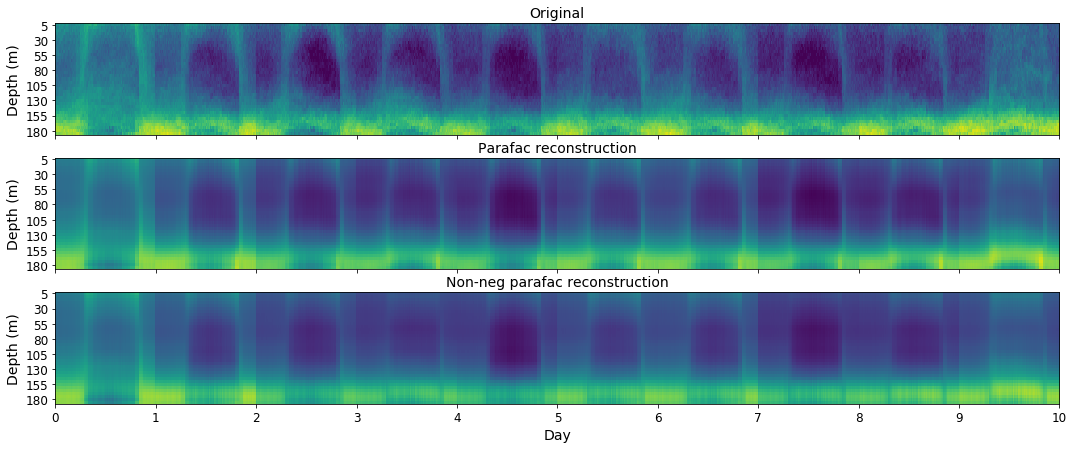

In [118]:
fig,ax = plt.subplots(3,1,figsize=(18,7),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor[0:10,:,:]),mode=1),aspect='auto',
            vmax=-57, vmin=-85)
ax[1].imshow(tl.unfold(tl.tensor(full_tensor[0:10,:,:]),mode=1), aspect='auto',
            vmax=-57, vmin=-85)
ax[2].imshow(tl.unfold(tl.tensor(full_tensor_nonneg[0:10,:,:]+sonar_tensor.min()),mode=1), aspect='auto',
            vmax=-57, vmin=-85)
for f in range(3):
    ax[f].set_xticks(range(0,11*144,144))
    ax[f].set_xticklabels(range(0,11,1))
    ax[f].set_yticks(range(0,37,5))
    ax[f].set_yticklabels((np.arange(0,37,5)+1)*depth_bin_size)
    plt.setp(ax[f].get_xticklabels(), fontsize=12)
    plt.setp(ax[f].get_yticklabels(), fontsize=12)
    if ax[f].is_last_row():
        plt.xlabel('Day',fontsize=14)
    ax[f].set_ylabel('Depth (m)',fontsize=14)
ax[0].set_title('Original', fontsize=14)
ax[1].set_title('Parafac reconstruction', fontsize=14)
ax[2].set_title('Non-neg parafac reconstruction', fontsize=14)
plt.show()

### Try reconstruction by hand using the factors

In [119]:
# Reconstruct a particular day
recons_day = 20

In [120]:
kh12_nonneg.shape

(5328, 4)

In [123]:
factors_kruskal_nonneg[0].shape

(62, 4)

In [124]:
recons_mtx = (factors_kruskal_nonneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
recons_vec.shape

(5328,)

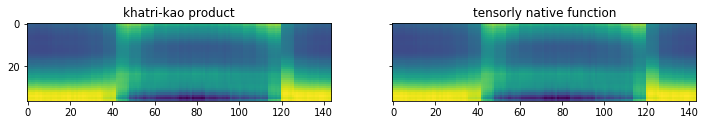

In [125]:
# Check if reconstruction is correct
fig,ax = plt.subplots(1,2,figsize=(12,2),sharey=True)
ax[0].imshow(recons_vec.reshape((37,144)))
ax[0].set_title('khatri-kao product')
ax[1].imshow(full_tensor_nonneg[recons_day,:])
ax[1].set_title('tensorly native function')
plt.show()

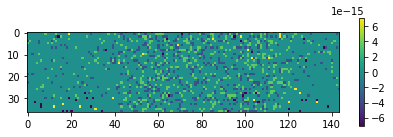

In [126]:
# Check errors in reconstruction via two different routes
fig = plt.figure(figsize=(7,2))
plt.imshow(recons_vec.reshape((37,144))-full_tensor_nonneg[recons_day,:])
plt.colorbar()
plt.show()

### Check sparse component

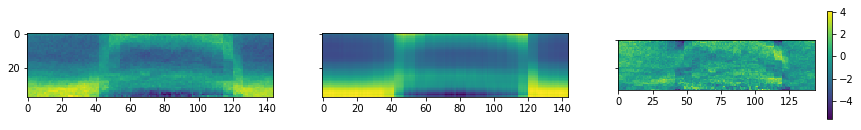

In [129]:
# Check low-rank and sparse component
recons_day = 20
fig,ax = plt.subplots(1,3,figsize=(15,2),sharey=True)
ax[0].imshow(sonar_tensor[recons_day,:,:])
ax[1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min())
im2 = ax[2].imshow(sonar_tensor[recons_day,:,:]-full_tensor_nonneg[recons_day,:]-sonar_tensor.min())
plt.colorbar(im2)
plt.show()

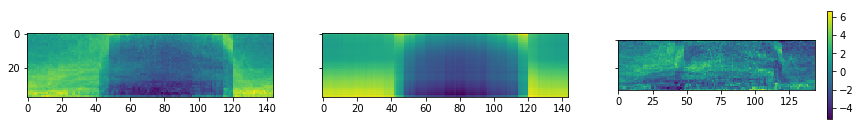

In [130]:
# Check low-rank and sparse component
recons_day = 45
fig,ax = plt.subplots(1,3,figsize=(15,2),sharey=True)
ax[0].imshow(sonar_tensor[recons_day,:,:])
ax[1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min())
im2 = ax[2].imshow(sonar_tensor[recons_day,:,:]-full_tensor_nonneg[recons_day,:]-sonar_tensor.min())
plt.colorbar(im2)
plt.show()

### Check how each component look like

In [132]:
(factors_kruskal[0].shape, factors_kruskal[1].shape, factors_kruskal[2].shape)

((62, 4), (37, 4), (144, 4))

In [139]:
# Khatri-kao product to combine the factors
kr12 = khatri_rao((factors_kruskal[1],factors_kruskal[2]))
kr01 = khatri_rao((factors_kruskal[0],factors_kruskal[1]))
kr02 = khatri_rao((factors_kruskal[0],factors_kruskal[2]))
kr12_nonneg = khatri_rao((factors_kruskal_nonneg[1],factors_kruskal_nonneg[2]))
kr01_nonneg = khatri_rao((factors_kruskal_nonneg[0],factors_kruskal_nonneg[1]))
kr02_nonneg = khatri_rao((factors_kruskal_nonneg[0],factors_kruskal_nonneg[2]))

In [140]:
(kr12.shape, kr01.shape, kr02.shape)

((5328, 4), (2294, 4), (8928, 4))

First check the factors:

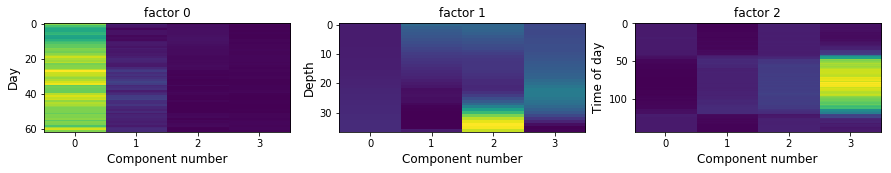

In [141]:
fig,ax = plt.subplots(1,3,figsize=(15,2))
for i in range(3):
    ax[i].imshow(factors_kruskal_nonneg[i],aspect='auto')
    ax[i].set_title('factor %d' % i)
    ax[i].set_xlabel('Component number',fontsize=12)
    if i==0:
        ax[i].set_ylabel('Day',fontsize=12)
    elif i==1:
        ax[i].set_ylabel('Depth',fontsize=12)
    else:
        ax[i].set_ylabel('Time of day',fontsize=12)
    ax[i].set_xticks(np.arange(4))

Making sense out of the factors:
- factor 0 is activation of each component along the day axis
- factor 1 is activation of each component along the depth axis
- factor 2 is activation of each component along the time-of-day axis

Now we look at the khatri-rao product of the factors:

1. factor1 $\otimes$ factor2: dimension [Depth x Time of day]

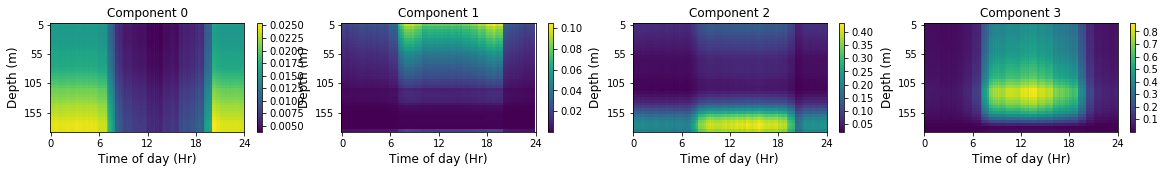

In [178]:
fac_num = kruskal_rank
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.title('Component %d'% fac)    
    plt.imshow(kh12_nonneg[:,fac].reshape(37,144),aspect='auto')
    plt.xticks(np.arange(0,145,36), np.arange(0,25,6))
    plt.xlabel('Time of day (Hr)', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

2. factor0 $\otimes$ factor1: dimension [Depth x Day]

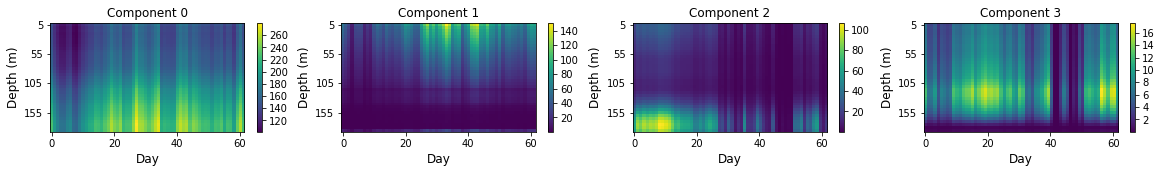

In [177]:
fac_num = kruskal_rank
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh01_nonneg[:,fac].reshape(62,37).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.yticks(np.arange(0,37,10),(np.arange(0,37,10)+1)*depth_bin_size)
    plt.ylabel('Depth (m)', fontsize=12)
    plt.colorbar()

3. factor0 $\otimes$ factor2: dimension [Time of day x Day]

Now we look at each factor individually:

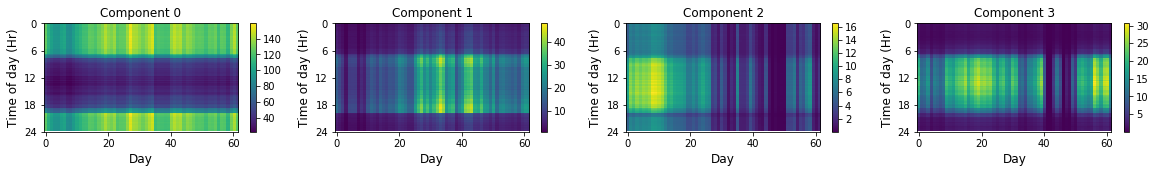

In [176]:
fac_num = kruskal_rank
fig = plt.figure(figsize=(20,2))
for fac in range(fac_num):
    fig.add_subplot(1,fac_num,fac+1)
    plt.imshow(kh02_nonneg[:,fac].reshape(62,144).T,aspect='auto')
    plt.title('Component %d'% fac)
    plt.yticks(np.arange(0,145,36), np.arange(0,25,6))
    plt.ylabel('Time of day (Hr)', fontsize=12)
    plt.xticks(np.arange(0,62,20))
    plt.xlabel('Day', fontsize=12)
    plt.colorbar()

factor2: Time of day

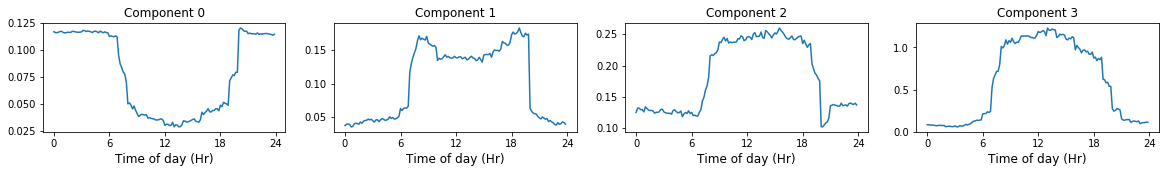

In [190]:
fig,ax = plt.subplots(1,kruskal_rank,figsize=(20,2))
for i in range(kruskal_rank):
    ax[i].plot(factors_kruskal_nonneg[2][:,i],label=i)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xticks(np.arange(0,145,36))
    ax[i].set_xticklabels(np.arange(0,25,6))
    ax[i].set_xlabel('Time of day (Hr)', fontsize=12)
plt.show()

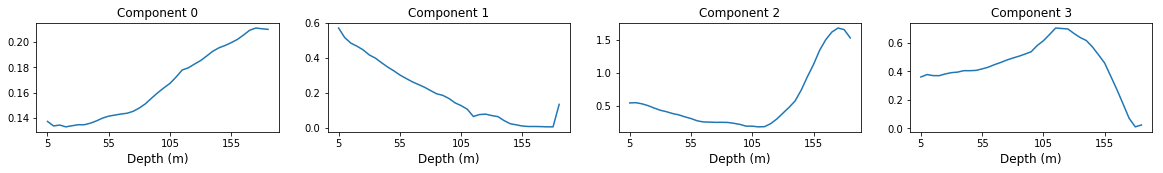

In [189]:
fig,ax = plt.subplots(1,kruskal_rank,figsize=(20,2))
for i in range(kruskal_rank):
    ax[i].plot(factors_kruskal_nonneg[1][:,i],label=i)
    ax[i].set_xticks(np.arange(0,37,10))
    ax[i].set_xticklabels((np.arange(0,37,10)+1)*depth_bin_size)
    ax[i].set_title('Component %d'% i)
    ax[i].set_xlabel('Depth (m)',fontsize=12)
plt.show()

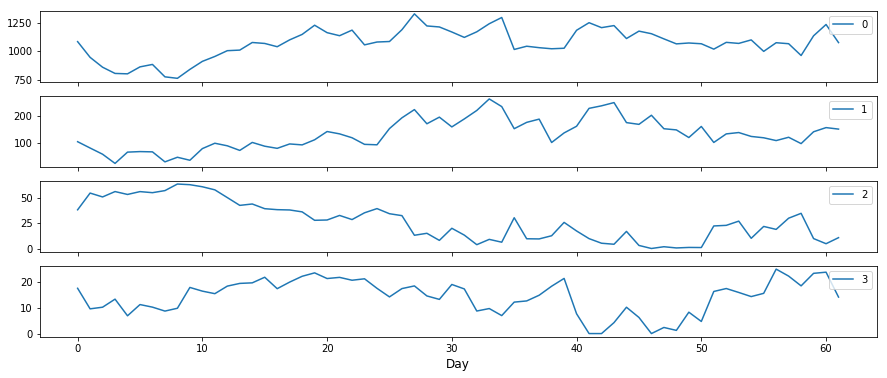

In [194]:
fig,ax = plt.subplots(kruskal_rank,1,figsize=(15,6),sharex=True)
for i in range(kruskal_rank):
    ax[i].plot(factors_kruskal_nonneg[0][:,i],label=i)
    ax[i].legend(loc='upper right')
ax[i].set_xlabel('Day',fontsize=12)
plt.show()

### Similarity between the components

In [202]:
k = factors_kruskal_nonneg[0].T
k_norm = k.T-k.min(axis=1)
k_norm = k_norm/k_norm.max(axis=0)
k_norm.shape

(62, 4)

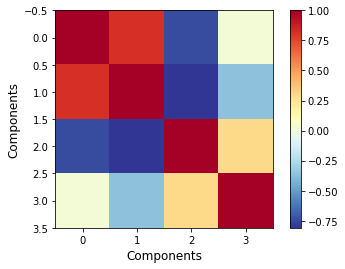

In [203]:
plt.imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
plt.colorbar()
plt.xlabel('Components', fontsize=12)
plt.ylabel('Components', fontsize=12)
plt.show()

### Similarity between days

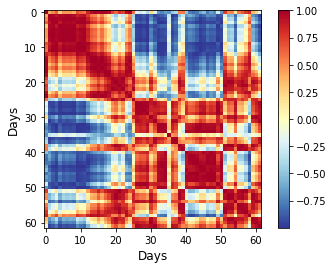

In [205]:
plt.imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
plt.colorbar()
plt.xlabel('Days', fontsize=12)
plt.ylabel('Days', fontsize=12)
plt.show()

### Reconstruction using a subset of components?

In [215]:
# Set which day
recons_day = 20

# Use all factors
recons_mtx = (factors_kruskal_nonneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
# recons_vec.shape

# Use factors [0,1,2]
recons_mtx_012 = (factors_kruskal_nonneg[0][recons_day,[0,1,2]]*kh12_nonneg[:,[0,1,2]]).T
recons_vec_012 = np.sum(recons_mtx_012,axis=0)
# recons_vec_024.shape

# Use factors [1,2,3]
recons_mtx_123 = (factors_kruskal_nonneg[0][recons_day,[1,2,3]]*kh12_nonneg[:,[1,2,3]]).T
recons_vec_123 = np.sum(recons_mtx_123,axis=0)

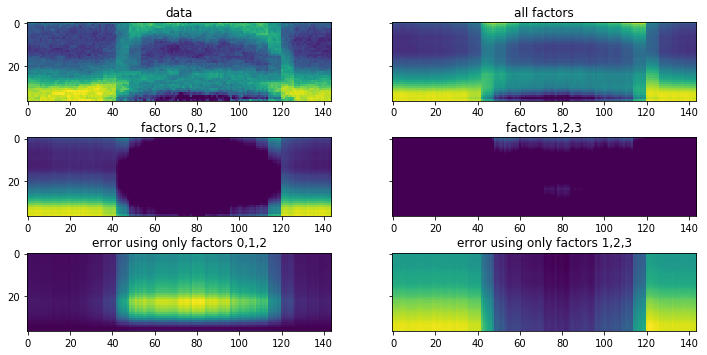

In [217]:
# Check low-rank and sparse component
fig,ax = plt.subplots(3,2,figsize=(12,6),sharey=True)
ax[0,0].imshow(sonar_tensor[recons_day,:,:],vmin=-76,vmax=-61)
ax[0,0].set_title('data')
ax[0,1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[0,1].set_title('all factors')
ax[1,0].imshow(recons_vec_012.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,0].set_title('factors 0,1,2')
ax[1,1].imshow(recons_vec_123.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,1].set_title('factors 1,2,3')
ax[2,0].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_012.reshape((37,144)))
ax[2,0].set_title('error using only factors 0,1,2')
ax[2,1].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_123.reshape((37,144)))
ax[2,1].set_title('error using only factors 1,2,3')
plt.show()

In [218]:
# Set which day
recons_day = 0

# Use all factors
recons_mtx = (factors_kruskal_nonneg[0][recons_day,:]*kh12_nonneg).T
recons_vec = np.sum(recons_mtx,axis=0)
# recons_vec.shape

# Use factors [0,1,2]
recons_mtx_012 = (factors_kruskal_nonneg[0][recons_day,[0,1,2]]*kh12_nonneg[:,[0,1,2]]).T
recons_vec_012 = np.sum(recons_mtx_012,axis=0)
# recons_vec_024.shape

# Use factors [1,2,3]
recons_mtx_123 = (factors_kruskal_nonneg[0][recons_day,[1,2,3]]*kh12_nonneg[:,[1,2,3]]).T
recons_vec_123 = np.sum(recons_mtx_123,axis=0)

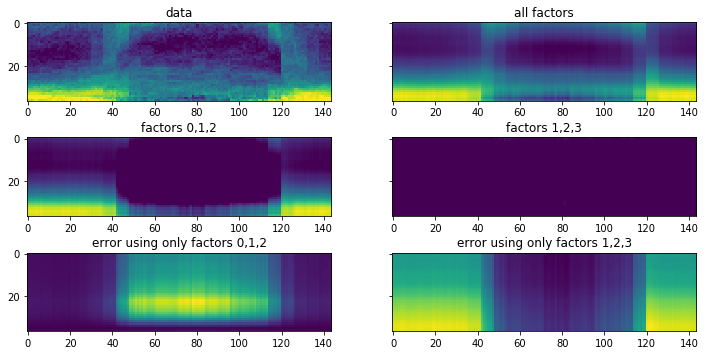

In [219]:
# Check low-rank and sparse component
fig,ax = plt.subplots(3,2,figsize=(12,6),sharey=True)
ax[0,0].imshow(sonar_tensor[recons_day,:,:],vmin=-76,vmax=-61)
ax[0,0].set_title('data')
ax[0,1].imshow(full_tensor_nonneg[recons_day,:]+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[0,1].set_title('all factors')
ax[1,0].imshow(recons_vec_012.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,0].set_title('factors 0,1,2')
ax[1,1].imshow(recons_vec_123.reshape((37,144))+sonar_tensor.min(),vmin=-76,vmax=-61)
ax[1,1].set_title('factors 1,2,3')
ax[2,0].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_012.reshape((37,144)))
ax[2,0].set_title('error using only factors 0,1,2')
ax[2,1].imshow(full_tensor_nonneg[recons_day,:]-recons_vec_123.reshape((37,144)))
ax[2,1].set_title('error using only factors 1,2,3')
plt.show()

## Iterate number of components and check clusters across days

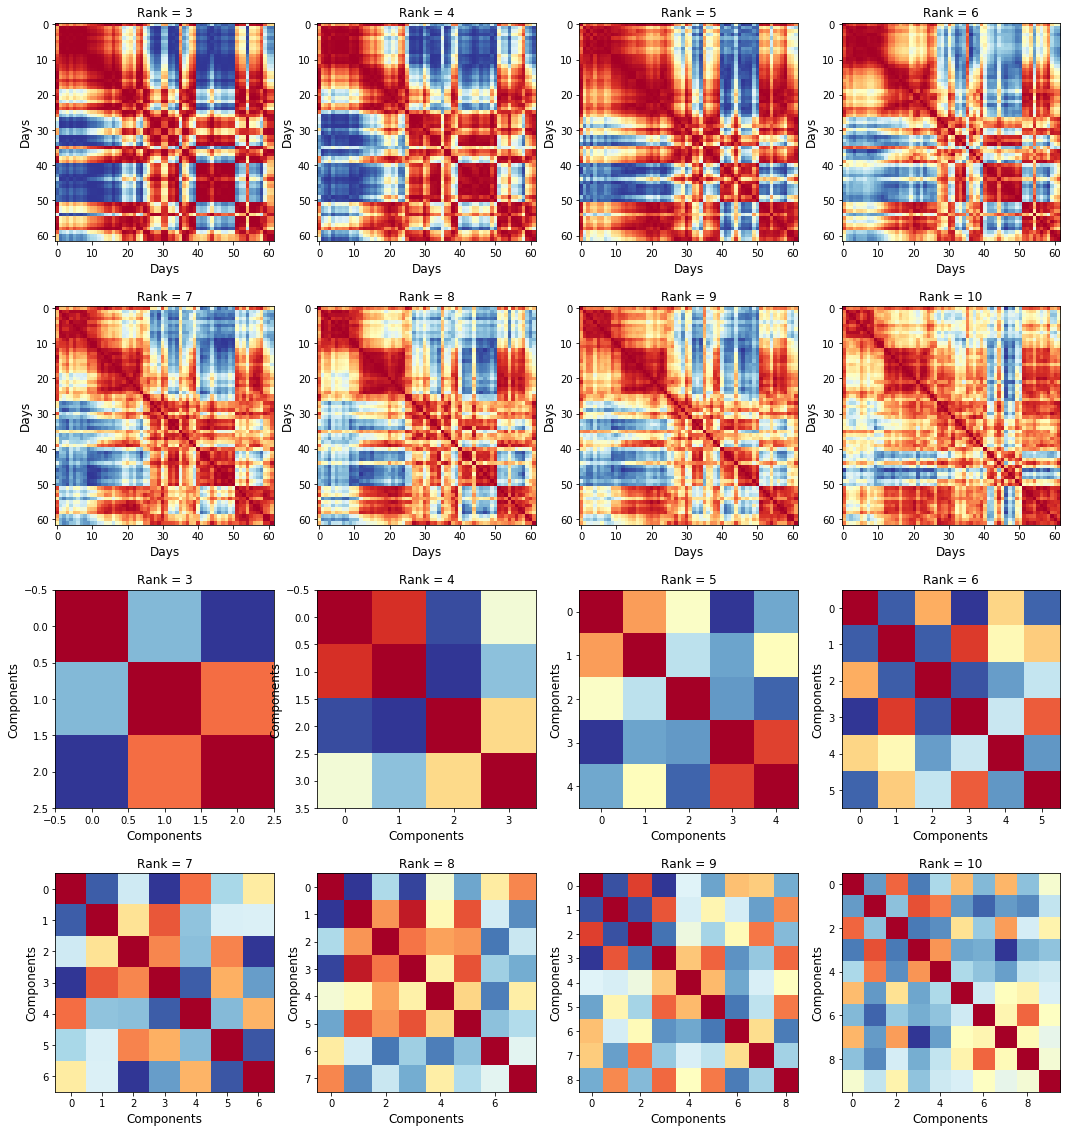

In [239]:
rank_all = np.arange(3,11,1)
fig,ax = plt.subplots(4,4,figsize=(18,20))
for r in rank_all:
    kruskal_nonneg_rank = r
    factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank=kruskal_nonneg_rank)
    k = factors_kruskal_noneg[0].T
    k_norm = k.T-k.min(axis=1)
    k_norm = k_norm/k_norm.max(axis=0)
    i,j = np.divmod(r-rank_all[0],4)
    
    # Similarity between days
    ax[i,j].imshow(np.corrcoef(k_norm),cmap='RdYlBu_r')
    ax[i,j].set_title('Rank = %d'%r)
    ax[i,j].set_xlabel('Days',fontsize=12)
    ax[i,j].set_ylabel('Days',fontsize=12)
    
    # Similarity between component
    ax[i+2,j].imshow(np.corrcoef(k_norm.T),cmap='RdYlBu_r')
    ax[i+2,j].set_title('Rank = %d'%r)
    ax[i+2,j].set_xlabel('Components',fontsize=12)
    ax[i+2,j].set_ylabel('Components',fontsize=12)

### Check fit/error with different rank

(3, 1930740.6595063552)
(4, 784258.5310179398)
(5, 764482.628573772)
(6, 799374.3725875856)
(7, 678947.8364557634)
(8, 660558.6165328921)
(9, 564952.8732988988)
(10, 550298.5452072154)


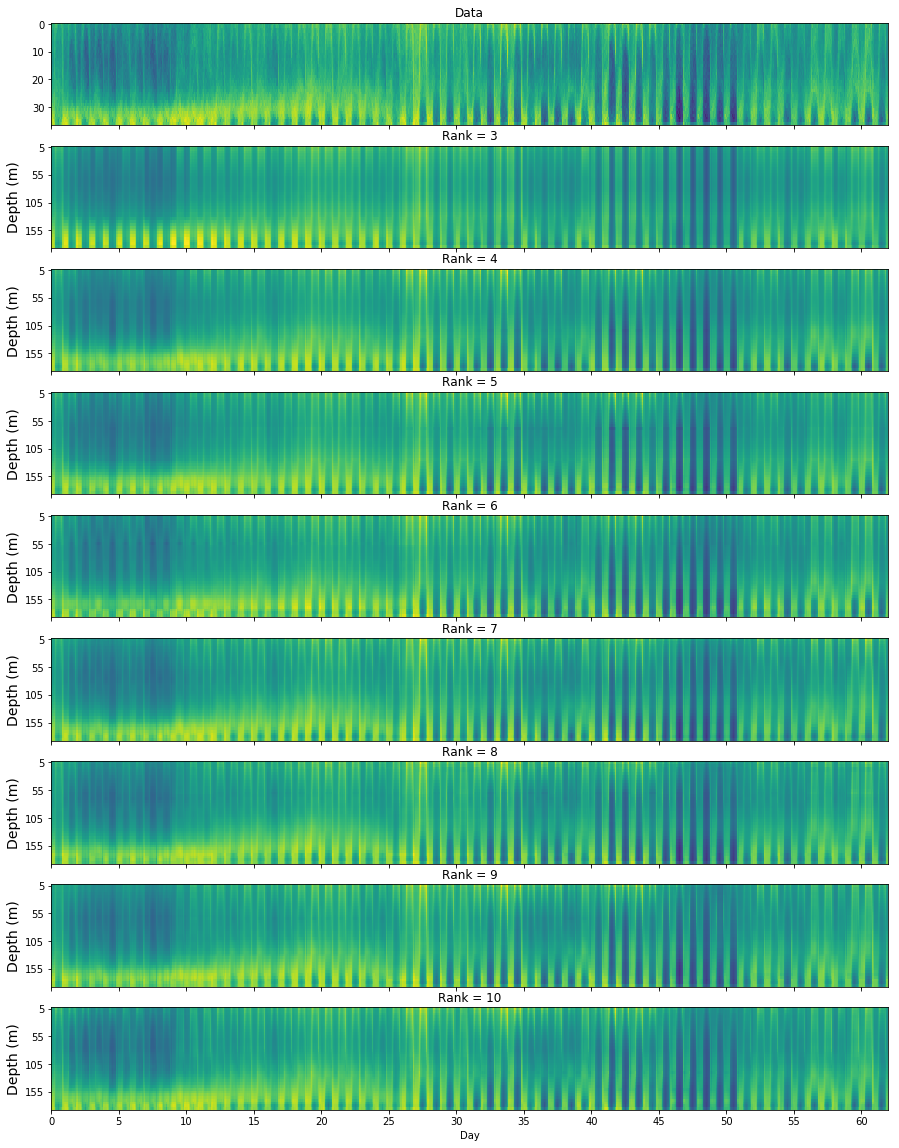

In [231]:
rank_all = np.arange(3,11,1)
e_all = []
fig,ax = plt.subplots(9,1,figsize=(15,20),sharex=True)
ax[0].imshow(tl.unfold(tl.tensor(sonar_tensor),mode=1), 
               aspect='auto', vmin=-97,vmax=-57)
ax[0].set_xticks(range(0,62*144,144*5), range(0,62,5))
ax[0].set_title('Data')
for seq,r in enumerate(rank_all):
    kruskal_nonneg_rank = r
    factors_kruskal_noneg = non_negative_parafac(sonar_tensor-sonar_tensor.min(), rank=kruskal_nonneg_rank)
    full_tensor_nonneg = tl.kruskal_to_tensor(factors_kruskal_noneg)
    e = tl.unfold(tl.tensor(sonar_tensor-sonar_tensor.min()),mode=1)-tl.unfold(tl.tensor(full_tensor_nonneg),mode=1)
    print((r, np.sum(e**2)))
    e_all.append(np.sum(e**2))
    
    ax[seq+1].imshow(tl.unfold(tl.tensor(full_tensor_nonneg)+sonar_tensor.min(),mode=1), 
                   aspect='auto', vmin=-97,vmax=-57)
    ax[seq+1].set_xticks(range(0,62*144,144*5))
    ax[seq+1].set_xticklabels(range(0,62,5))
    ax[seq+1].set_title('Rank = %d'%r)
    ax[seq+1].set_yticks(np.arange(0,37,10))
    ax[seq+1].set_yticklabels((np.arange(0,37,10)+1)*depth_bin_size)
    ax[seq+1].set_ylabel('Depth (m)', fontsize=14)
plt.xlabel('Day')
plt.show()

Text(0,0.5,'Squared error')

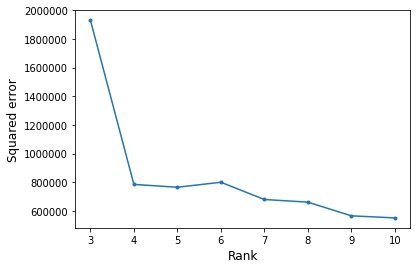

In [238]:
# Check squared error
plt.plot(rank_all,np.array(e_all),'.-')
plt.xlabel('Rank',fontsize=12)
plt.ylabel('Squared error',fontsize=12)

In [357]:
np.sum(e**2)

764482.628573645